# Notebook Iteracion 6 Modelado

### Objetivo: Implementación de clustering como originador de una nueva variable que categoriza los precios y se usa como entrada para el modelo de predicción de precios:
- Analisis de distribución de la variable precio
- Analisis de variables predictoras
- Ejecución de clustering
- Entrenamiento de modelos


In [1]:
# Funciones generales
import sys
sys.path.append('../')
# A medida que avanzan las iteraciones se crearan mas funcinoes transversales
from funciones import *

# Tuneo de hiperparámetros
from sklearn.model_selection import ParameterGrid

# Libreria para manejo de balance de datos
import smogn

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# Grid Search Validacion cruzada
from sklearn.model_selection import GridSearchCV

# xgboost
import xgboost as xgb

# Métricas de evaluación
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

**Lectura de datos**
Dada la estabilidad que muestra el resultado de la iteracion 2 sobre las variables predictoras, se utiliza la base resultante de esta

In [2]:
import os 
# get current directory
path = os.getcwd()
# parent directory
path = os.path.abspath('../')
data_model = pd.read_csv(path + "/iteracion_2/datos_iteracion_2.csv")
data_model.head()

,precio,zona,barrio_sector,baños_familiares,area_bruta,numero_niveles,parqueaderos,alcobas_familiares,estrato,area_total,...,closet_de_linos,biblioteca,parqueadero_visitantes,gimnasio,piscina,salon_social,dispositivos_automatizacion,alarma,tipo_cocina_freq,tipo_pisos_freq
0,1100000.0,centro,castilla,1.0,95.0,1.0,0.0,3.0,0.0,95.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.861534,0.596709
1,950000.0,centro,el salvador,1.0,70.0,1.0,0.0,2.0,3.0,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081652,0.596709
2,970000.0,centro,los angeles,1.0,38.0,1.0,0.0,1.0,4.0,38.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081652,0.596709
3,1400000.0,centro,prado,1.0,50.0,1.0,1.0,2.0,0.0,50.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.861534,0.596709
4,800000.0,centro,12 de octubre,1.0,92.0,1.0,0.0,3.0,2.0,92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.861534,0.596709


**Distribución de variable precio**

Variable precio en su distribución original luego de las iteraciones 1 y 3, esta será la distribución sobre la cúal se aplique el clustering

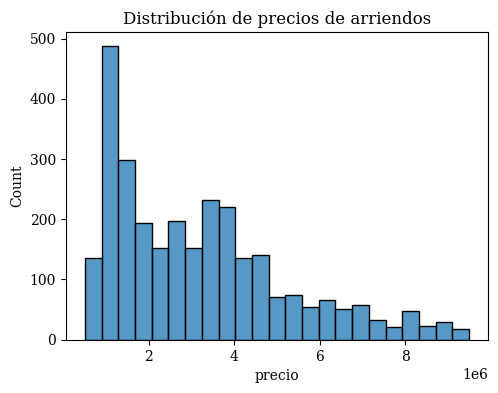

In [3]:
graficar_distribucion_histograma(data_model, 'precio')

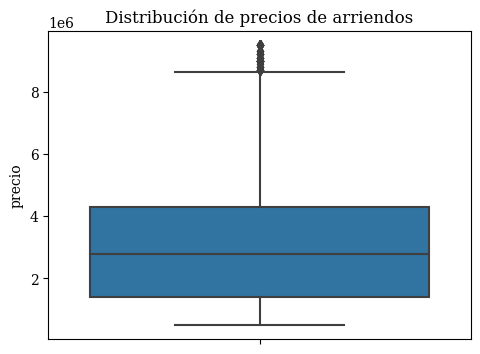

In [4]:
graficar_distribucion_boxplot(data_model, 'precio')

**Separación de las variables**

Las variables obtenidas por el proceso de scraping se dividen en tres tipos que es importante separar para hacer un analisis mas detallado, estas son:
- Variables categóricas: Variables booleana que indican si un inmueble cuenta con una comodidad
- Variables categoricas numéricas: Variables discretas numéricas
- Variables numéricas: Variables continuas

In [5]:
pred_columns = [
    'baños_familiares',
    'area_bruta', 
    'numero_niveles',
    'parqueaderos', 
    'alcobas_familiares', 
    'estrato', 
    'area_total',
    'juegos_infantiles', 
    'balcon', 
    'zona_ropas', 
    'camaras_cctv',
    'cancha_polideportiva', 
    'ascensor', 
    'cancha_squash', 
    'zona_bbq',
    'patio', 
    'unidad_cerrada_conjunto', 
    'zonas_verdes',
    'aire_acondicionado', 
    'jacuzzi', 
    'red_de_Gas', 
    'turco', 
    'porteria_24_7',
    'sauna', 
    'calentador_de_agua', 
    'terraza', 
    'closet_de_linos',
    'biblioteca', 
    'parqueadero_visitantes', 
    'gimnasio', 
    'piscina',
    'salon_social', 
    'dispositivos_automatizacion', 
    'alarma',
    'tipo_cocina_freq', 
    'tipo_pisos_freq'
]

**Variables predictoras**

En la iteración 2 el analisis de distribución y correlaciones dió como resultado la eliminación de las variables:

- columns_disc_corr
- numero_niveles
- zona_ropas
- camaras_cctv
- cancha_polideportiva
- cancha_squash
- zona_bbq
- patio
- aire_acondicionado
- jacuzzi
- red_de_Gas
- terraza
- dispositivos_automatizacion
- alarma
- area_total
- porteria_24_7

Se reutiliza estas variables, sin embargo, por criterio del negocio se conservan las siguientes variables dejando su eliminación para un posterior analisis de importancia de variables:

- cancha_polideportiva


In [6]:
columns_disc_corr = [
    "numero_niveles",
    "zona_ropas",
    "camaras_cctv",
    "cancha_squash",
    "zona_bbq",
    "patio",
    "aire_acondicionado",
    "jacuzzi",
    "red_de_Gas",
    "terraza",
    "dispositivos_automatizacion",
    "alarma",
    "area_total",
    "porteria_24_7"
]

**Estandarización**

In [7]:
X = data_model[pred_columns]
Y = data_model['precio']

In [8]:
X_est = estandarizar(X)

**Clustering**

Se procede con la ejecucion del algoritmo de kmeans entre las variables __precio__ y __area_bruta__, esta última por ser la mas relevante en la ejecución del modelo línea base y el análisis de correlaciones

In [9]:
X_est['precio'] = Y.values

In [10]:
x_cluster = X_est[['estrato', 'area_bruta']].values
for k in [2,3,4,5]:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")
    kmeans_labels = kmeans.fit_predict(x_cluster)
    sample_silhouette_values = silhouette_samples(x_cluster, kmeans_labels)
    print("silhouette_score k = {} : {}".format(k , sample_silhouette_values.mean()))

silhouette_score k = 2 : 0.5584902744604046
silhouette_score k = 3 : 0.6143361136796931
silhouette_score k = 4 : 0.5603650463061598
silhouette_score k = 5 : 0.5731226948655109


In [11]:
x_cluster

array([[0.        , 0.16510319],
       [0.5       , 0.11819887],
       [0.66666667, 0.05816135],
       ...,
       [0.5       , 0.08067542],
       [0.5       , 0.08630394],
       [0.5       , 0.08442777]])

Segun el cálculo del coeficiente de siluetas se obtiene un mejor resultado para 3 clusters, se selecciona este valor para hacer la división de los datos

Entrenamiento y cálculo de las etiquetas de los clusters

In [12]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto")
kmeans_labels = kmeans.fit_predict(x_cluster)

Se añade la etiqueta cluster como nueva variable de la base de entrenamiento

In [13]:
X_est['cluster'] = kmeans_labels

Se grafica la distribución de los clusters para visualizar la distribución de los grupos

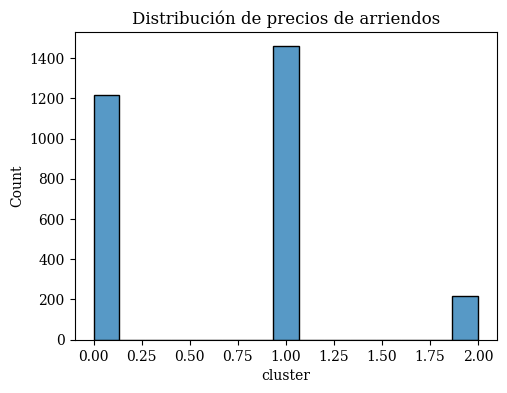

In [14]:
graficar_distribucion_histograma(X_est, 'cluster')

Los rangos de precios de cada cluster son:

In [15]:
print("Cluster 0: ", X_est[X_est['cluster']==0]['precio'].min(), X_est[X_est['cluster']==0]['precio'].max())
print("Cluster 1: ", X_est[X_est['cluster']==1]['precio'].min(), X_est[X_est['cluster']==1]['precio'].max())
print("Cluster 2: ", X_est[X_est['cluster']==2]['precio'].min(), X_est[X_est['cluster']==2]['precio'].max())

Cluster 0:  500000.0 9000000.0
Cluster 1:  700000.0 9500000.0
Cluster 2:  550000.0 8700000.0


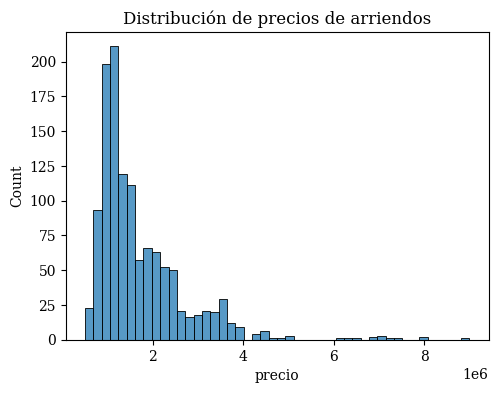

In [16]:
graficar_distribucion_histograma( X_est[X_est['cluster']==0], 'precio')

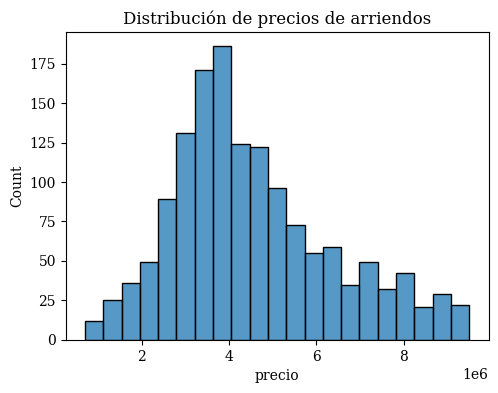

In [17]:
graficar_distribucion_histograma( X_est[X_est['cluster']==1], 'precio')

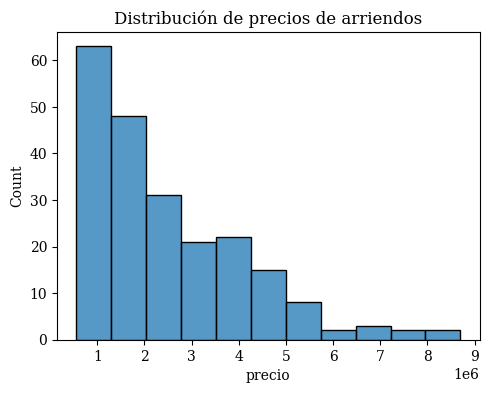

In [18]:
graficar_distribucion_histograma( X_est[X_est['cluster']==2], 'precio')

**Modelo**

La variacion de los hiperparámetros seleccionada corresponde al resultado de multiples ejecuciones observando los resultados obtenidos en los archivos csv que determinaron el aumento, disminución o eliminación de hiperparámetros

Se eliminan las variables de la base de modelado dado los anteriores análisis

In [19]:
X_cluster_0 = X_est[X_est['cluster'].isin([0])]
imprimir_dimensiones(X_cluster_0)

Numero de muestras: 1217, Número de columnas: 38


In [20]:
X_cluster_1 = X_est[X_est['cluster'].isin([1])]
X_cluster_1 = X_cluster_1[(X_cluster_1['precio'] >= 3800000) & (X_cluster_1['precio'] <= 6900000) ]
imprimir_dimensiones(X_cluster_1)

Numero de muestras: 695, Número de columnas: 38


In [21]:
X_cluster_2 = X_est[X_est['cluster'].isin([2])]
X_cluster_2 = X_cluster_2[(X_cluster_2['precio'] >= 2000000) & (X_cluster_2['precio'] <= 6900000)]
imprimir_dimensiones(X_cluster_2)

Numero de muestras: 102, Número de columnas: 38


In [22]:
X_concat = pd.concat([X_cluster_0, X_cluster_1, X_cluster_2])

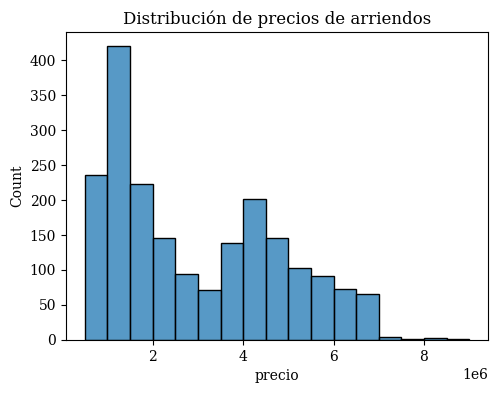

In [23]:
graficar_distribucion_histograma( X_concat, 'precio')

In [24]:
X_concat.columns

Index(['baños_familiares', 'area_bruta', 'numero_niveles', 'parqueaderos',
       'alcobas_familiares', 'estrato', 'area_total', 'juegos_infantiles',
       'balcon', 'zona_ropas', 'camaras_cctv', 'cancha_polideportiva',
       'ascensor', 'cancha_squash', 'zona_bbq', 'patio',
       'unidad_cerrada_conjunto', 'zonas_verdes', 'aire_acondicionado',
       'jacuzzi', 'red_de_Gas', 'turco', 'porteria_24_7', 'sauna',
       'calentador_de_agua', 'terraza', 'closet_de_linos', 'biblioteca',
       'parqueadero_visitantes', 'gimnasio', 'piscina', 'salon_social',
       'dispositivos_automatizacion', 'alarma', 'tipo_cocina_freq',
       'tipo_pisos_freq', 'precio', 'cluster'],
      dtype='object')

In [25]:
x_model = X_concat.drop(columns = columns_disc_corr)
x_model = x_model.drop(columns='precio')
y_model = X_concat['precio']
imprimir_dimensiones(x_model)

Numero de muestras: 2014, Número de columnas: 23


**Dvisión de los datos:** Entrenamiento 75%, Test 25%

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x_model, y_model, test_size = 0.25, train_size = 0.75, random_state = 17)
print("Tamaño de los Datos de Entrenamiento = ", x_train.shape)
print("Tamaño de los Datos de Validación = ", x_test.shape)
print("Tamaño del Vector de Clases de Entrenamiento = ", y_train.shape)
print("Tamaño del Vector de Clases de Prueba = ", y_test.shape)

Tamaño de los Datos de Entrenamiento =  (1510, 23)
Tamaño de los Datos de Validación =  (504, 23)
Tamaño del Vector de Clases de Entrenamiento =  (1510,)
Tamaño del Vector de Clases de Prueba =  (504,)


**XGBOOST**

In [27]:
for column in x_train.columns:
    if column not in ['area_bruta', 'tipo_cocina_fre', 'tipo_pisos_freq']:
        x_train[column] = x_train[column].astype('float') 

for column in x_test.columns:
    if column not in ['area_bruta', 'tipo_cocina_fre', 'tipo_pisos_freq']:
        x_test[column] = x_test[column].astype('float') 

In [28]:
param_grid_xgb = ParameterGrid({
    'n_estimators' : [80, 100, 120, 140],
    'max_depth' : [5, 7, 9, 10, 11],
    'learning_rate' : [.02,.03, .05],
    'objective' : ['reg:squarederror'],
    'subsample' : [0.2, 0.3, 0.5],
    'eta' : [.01, .05, .07],
})
# Ejecuciones del modelo
ejecutar_modelo(model = "XGBRegressor", 
                x_train=x_train, 
                y_train=y_train, 
                x_test=x_test, 
                y_test=y_test, 
                params=param_grid_xgb, 
                filename='XGBRegressor')

Modelo: {'eta': 0.01, 'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 80, 'objective': 'reg:squarederror', 'subsample': 0.2}
Modelo: {'eta': 0.01, 'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 80, 'objective': 'reg:squarederror', 'subsample': 0.3}
Modelo: {'eta': 0.01, 'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 80, 'objective': 'reg:squarederror', 'subsample': 0.5}
Modelo: {'eta': 0.01, 'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.2}
Modelo: {'eta': 0.01, 'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.3}
Modelo: {'eta': 0.01, 'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.5}
Modelo: {'eta': 0.01, 'learning_rate': 0.02, 'max_depth': 5, 'n_estimators': 120, 'objective': 'reg:squarederror', 'subsample': 0.2}
Modelo: {'eta': 0.01, 'learning_rate': 0.02, 'max_depth': 5, 'n_estimato

In [29]:
param_grid_xgb = {
    'n_estimators' : [100, 120],
    'max_depth' : [10],
    'learning_rate' : [.03],
    'objective' : ['reg:squarederror'],
    'subsample' : [0.2,0.3],
    'eta' : [.01,.05, .07],
}

grid = GridSearchCV(
        estimator  = xgb.XGBRegressor(random_state=123),
        param_grid = param_grid_xgb,
        scoring    = 'r2',
        n_jobs     = - 1,
        cv         = 5, 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X=x_train, y= y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=123, ...),
             n_jobs=-1,
             param_grid={'eta': [0.01, 0.05, 0.07], 'learning_rate': [0.03],
                         'max_depth': [10], 'n_estimators': [100, 120],
                         'objective': ['reg:squarederror'],
                         'subsample': [0.2, 0.3]},
             return_train_score=True, scoring='r2')

In [30]:
grid.best_params_

{'eta': 0.01,
 'learning_rate': 0.03,
 'max_depth': 10,
 'n_estimators': 120,
 'objective': 'reg:squarederror',
 'subsample': 0.3}

In [31]:
xgb_final = grid.best_estimator_

In [32]:
resultados_cv = pd.DataFrame(grid.cv_results_)
resultados_cv.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(10)

,param_eta,param_learning_rate,param_max_depth,param_n_estimators,param_objective,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
3,0.01,0.03,10,120,reg:squarederror,0.3,0.844070,0.017791,0.927780,0.002464
7,0.05,0.03,10,120,reg:squarederror,0.3,0.844070,0.017791,0.927780,0.002464
11,0.07,0.03,10,120,reg:squarederror,0.3,0.844070,0.017791,0.927780,0.002464
2,0.01,0.03,10,120,reg:squarederror,0.2,0.842295,0.018816,0.908783,0.002313
6,0.05,0.03,10,120,reg:squarederror,0.2,0.842295,0.018816,0.908783,0.002313
10,0.07,0.03,10,120,reg:squarederror,0.2,0.842295,0.018816,0.908783,0.002313
1,0.01,0.03,10,100,reg:squarederror,0.3,0.831210,0.017192,0.904143,0.002953
5,0.05,0.03,10,100,reg:squarederror,0.3,0.831210,0.017192,0.904143,0.002953
9,0.07,0.03,10,100,reg:squarederror,0.3,0.831210,0.017192,0.904143,0.002953
0,0.01,0.03,10,100,reg:squarederror,0.2,0.828643,0.018897,0.886474,0.002165


In [34]:
mean_absolute_percentage_error(y_true=y_train, y_pred  = xgb_final.predict(x_train))

0.11047002388753722

In [35]:
mean_absolute_percentage_error(y_true=y_test, y_pred  = xgb_final.predict(x_test))

0.15738790267019095

In [37]:
X_est['zona'] = data_model['zona']

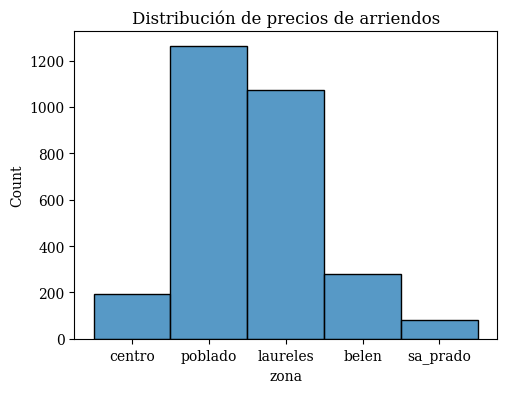

In [38]:
graficar_distribucion_histograma( X_est, 'zona')

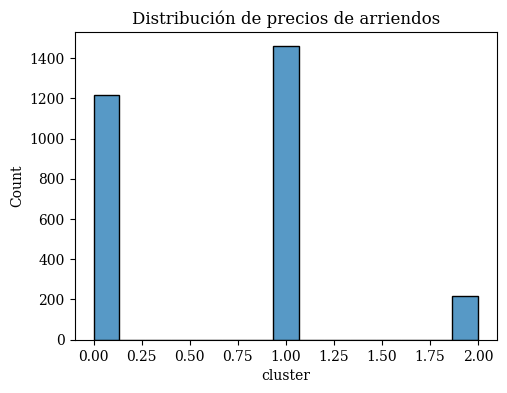

In [39]:
graficar_distribucion_histograma( X_est, 'cluster')

In [40]:
columns_test_zones = list(x_train.columns)
columns_test_zones.extend(['zona', 'precio'])
columns_test_zones

['baños_familiares',
 'area_bruta',
 'parqueaderos',
 'alcobas_familiares',
 'estrato',
 'juegos_infantiles',
 'balcon',
 'cancha_polideportiva',
 'ascensor',
 'unidad_cerrada_conjunto',
 'zonas_verdes',
 'turco',
 'sauna',
 'calentador_de_agua',
 'closet_de_linos',
 'biblioteca',
 'parqueadero_visitantes',
 'gimnasio',
 'piscina',
 'salon_social',
 'tipo_cocina_freq',
 'tipo_pisos_freq',
 'cluster',
 'zona',
 'precio']

In [67]:
data_zonas = X_est[columns_test_zones]

In [68]:
data_model["zona"].unique()

array(['centro', 'poblado', 'laureles', 'belen', 'sa_prado'], dtype=object)

In [69]:
data_centro = data_zonas[data_zonas['zona'] == 'centro']
data_poblado = data_zonas[data_zonas['zona'] == 'poblado']
data_laureles = data_zonas[data_zonas['zona'] == 'laureles']
data_belen = data_zonas[data_zonas['zona'] == 'belen']
data_sa_prado = data_zonas[data_zonas['zona'] == 'sa_prado']

In [70]:
print('MAPE centro: ', mean_absolute_percentage_error(y_true=data_centro['precio'], y_pred  = xgb_final.predict(data_centro[x_train.columns])))
print('MAPE poblado: ', mean_absolute_percentage_error(y_true=data_poblado['precio'], y_pred  = xgb_final.predict(data_poblado[x_train.columns])))
print('MAPE laureles: ', mean_absolute_percentage_error(y_true=data_laureles['precio'], y_pred  = xgb_final.predict(data_laureles[x_train.columns])))
print('MAPE belen: ', mean_absolute_percentage_error(y_true=data_belen['precio'], y_pred  = xgb_final.predict(data_belen[x_train.columns])))
print('MAPE sa_prado: ', mean_absolute_percentage_error(y_true=data_sa_prado['precio'], y_pred  = xgb_final.predict(data_sa_prado[x_train.columns])))

MAPE centro:  0.2549462056362487
MAPE poblado:  0.23624572581579895
MAPE laureles:  0.33182004664330256
MAPE belen:  0.3512421248729886
MAPE sa_prado:  0.4490736614407065


In [71]:
data_cluster_0 = data_zonas[data_zonas['cluster'] == 0] 
data_cluster_1 = data_zonas[data_zonas['cluster'] == 1] 
data_cluster_2 = data_zonas[data_zonas['cluster'] == 2] 

In [72]:
print('MAPE cluster_0: ', mean_absolute_percentage_error(y_true=data_cluster_0['precio'], y_pred  = xgb_final.predict(data_cluster_0[x_train.columns])))
print('MAPE cluster_1: ', mean_absolute_percentage_error(y_true=data_cluster_1['precio'], y_pred  = xgb_final.predict(data_cluster_1[x_train.columns])))
print('MAPE cluster_2: ', mean_absolute_percentage_error(y_true=data_cluster_2['precio'], y_pred  = xgb_final.predict(data_cluster_2[x_train.columns])))

MAPE cluster_0:  0.13605567833382864
MAPE cluster_1:  0.34518257975520206
MAPE cluster_2:  0.7820902829504309


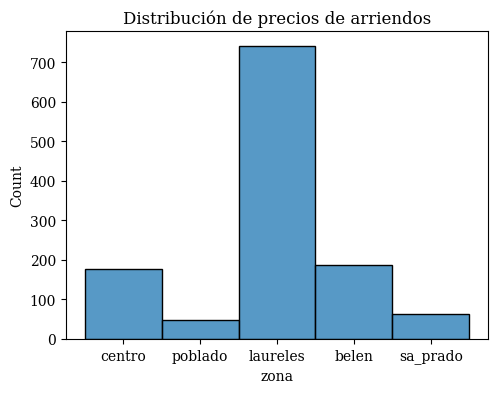

In [73]:
graficar_distribucion_histograma( data_cluster_0, 'zona')

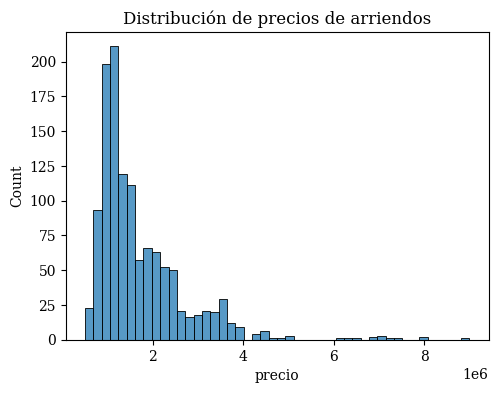

In [74]:
graficar_distribucion_histograma( data_cluster_0, 'precio')

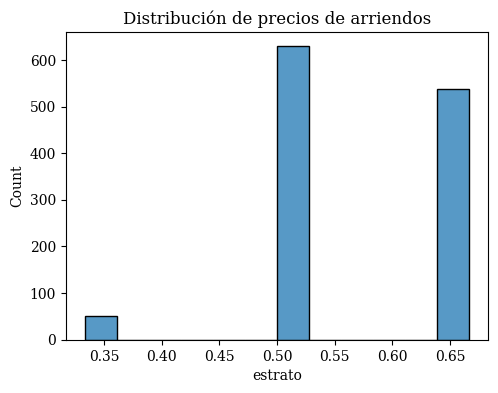

In [76]:
graficar_distribucion_histograma( data_cluster_0, 'estrato')

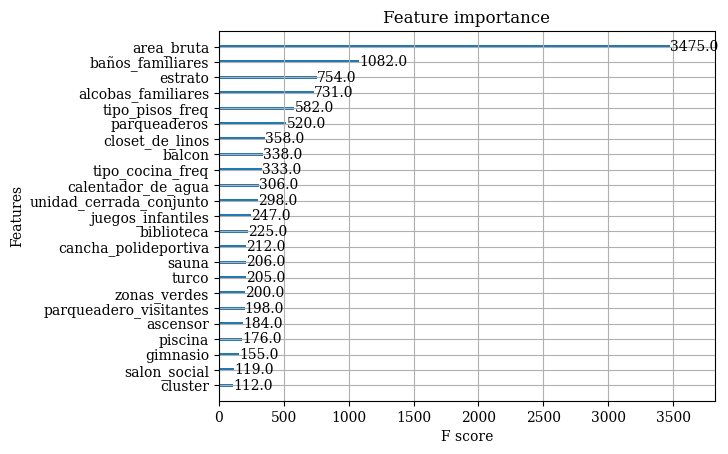

<Figure size 1600x1600 with 0 Axes>

In [90]:
xgb.plot_importance(xgb_final)
plt.figure(figsize = (16, 16))
plt.show()

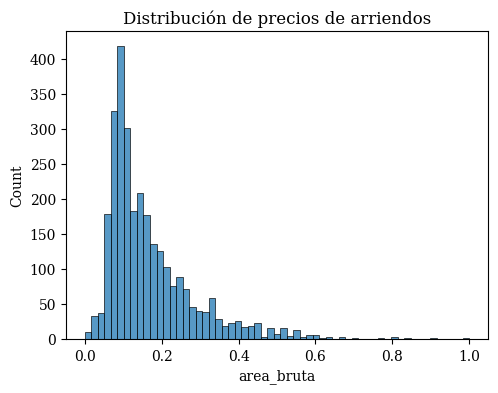

In [111]:
graficar_distribucion_histograma( data_zonas, 'area_bruta')

In [112]:
data_cluster_0.head()

,baños_familiares,area_bruta,parqueaderos,alcobas_familiares,estrato,juegos_infantiles,balcon,cancha_polideportiva,ascensor,unidad_cerrada_conjunto,...,biblioteca,parqueadero_visitantes,gimnasio,piscina,salon_social,tipo_cocina_freq,tipo_pisos_freq,cluster,zona,precio
1,0.2,0.118199,0.0,0.4,0.500000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.092158,1.000000,0,centro,950000.0
2,0.2,0.058161,0.0,0.2,0.666667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.092158,1.000000,0,centro,970000.0
4,0.2,0.159475,0.0,0.6,0.333333,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0,centro,800000.0
5,0.4,0.090056,0.0,0.6,0.500000,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.000000,1.000000,0,centro,1200000.0
6,0.4,0.099437,0.0,0.6,0.500000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.092158,0.062988,0,centro,1150000.0


In [133]:
data_test = data_zonas[(data_zonas['area_bruta'] >= 0.2) & (data_zonas['area_bruta'] <= 0.3) & (data_zonas['estrato'] == 0.5)]
data_test.

,baños_familiares,area_bruta,parqueaderos,alcobas_familiares,estrato,juegos_infantiles,balcon,cancha_polideportiva,ascensor,unidad_cerrada_conjunto,...,biblioteca,parqueadero_visitantes,gimnasio,piscina,salon_social,tipo_cocina_freq,tipo_pisos_freq,cluster,zona,precio
25,0.4,0.249531,0.0,0.8,0.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.092158,0.062988,0,centro,2100000.0
32,0.4,0.202627,0.0,0.6,0.5,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.062988,0,centro,1800000.0
33,0.4,0.202627,0.0,0.6,0.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.062988,0,centro,1800000.0
35,0.4,0.202627,0.0,0.6,0.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.062988,0,centro,1800000.0
40,0.4,0.212008,0.0,0.8,0.5,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0,centro,1800000.0


In [134]:
print('MAPE: ', mean_absolute_percentage_error(y_true=data_test['precio'].values, y_pred  = xgb_final.predict(data_test[x_train.columns])))

MAPE:  0.10174351031428924


In [135]:
data_test['precio']

25      2100000.0
32      1800000.0
33      1800000.0
35      1800000.0
40      1800000.0
41      1950000.0
52      2000000.0
129     2300000.0
1663    3000000.0
1666    1850000.0
1699    2300000.0
1706    1990000.0
1776    2500000.0
1846    2250000.0
2279    2000000.0
2615    2300000.0
2618    2200000.0
2633    2500000.0
2663    3550000.0
2666    3550000.0
2702    2500000.0
2828    1400000.0
Name: precio, dtype: float64

In [132]:
xgb_final.predict(data_test[x_train.columns])

array([2075640.9, 1781855.2, 1814516.9, 1814516.9, 1867534.9, 2368415.8,
       2290522. , 1621200.6, 1936703.6, 4826112. , 4844866.5, 5228081.5,
       5117190.5, 4598484.5, 4600309. , 3568054.5, 4572127. , 5284517.5,
       5684859. , 4827291.5, 4860981. , 5500422.5, 4005975.5, 5305056.5,
       4315304.5, 4470482.5, 4682888. , 4962214. , 4712099.5, 5623848. ,
       4676666. , 4185481. , 5139855. , 4566547. , 4989595. , 5438045.5,
       5697715.5, 5769192. , 4873843.5, 4362221.5, 4616922. , 5084799.5,
       4695960.5, 4924348. , 5296095.5, 4841990. , 4621385.5, 5018100. ,
       4739859.5, 3741544.2, 5381866.5, 4295085. , 4873795.5, 4704695.5,
       4696050.5, 5017948.5, 5526385.5, 5061419.5, 4818825.5, 4188768.2,
       4984491. , 5691792.5, 4660964.5, 5400976. , 5852466.5, 4484804.5,
       4736217. , 4930735.5, 4751329.5, 4787791.5, 5038024.5, 4996763.5,
       4733667.5, 3709520. , 5015185.5, 5409594. , 5301206.5, 5186347. ,
       4549939. , 5161098.5, 4654986.5, 4689972. , 